In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

from prominence_delineator import ProminenceDelineator
from utils import *

Load ECG Data

In [11]:
# Load first channel of 7th ECG record from the LUDB database
time, ecg, fs, annotations = load_ecg(record_name="sel100", lead="MLII", filtered=True, left=151000, right=156000)

Delineate / Detect Waves

In [3]:
# Create an instance of the ProminenceDelineator
PromDelineator = ProminenceDelineator(sampling_frequency=fs)
# Detect the R-peaks in the ECG signal
rpeaks = PromDelineator.find_rpeaks(ecg)
# Clean the ECG signal
ecg = PromDelineator.clean_ecg(ecg)
# Find waves in the ECG signal using the ProminenceDelineator
waves = PromDelineator.find_waves(ecg, rpeaks=rpeaks, include_nodetections=False)

Plot Annotations and Detections

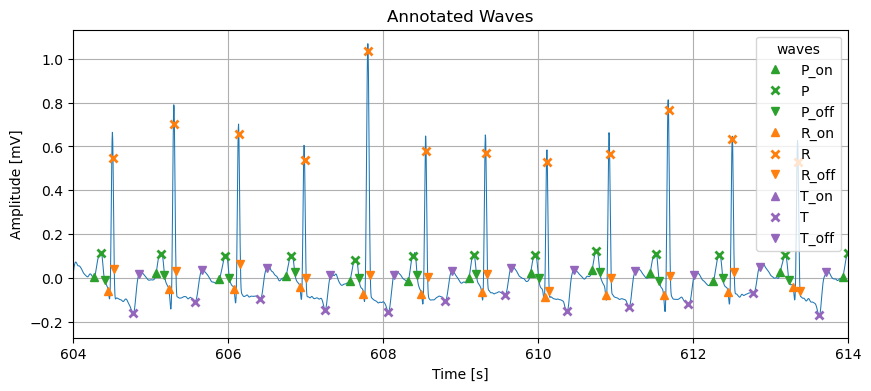

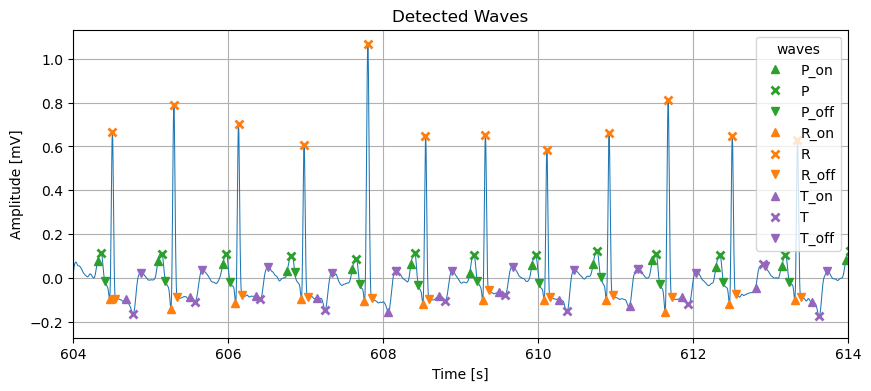

In [4]:
# Plot the annotated ECG signal
plot_waves(time, ecg, annotations, title="Annotated Waves", xlim=[time[0], time[0]+10])
# Plot the detected waves
plot_waves(time, ecg, waves, title="Detected Waves", xlim=[time[0], time[0]+10])

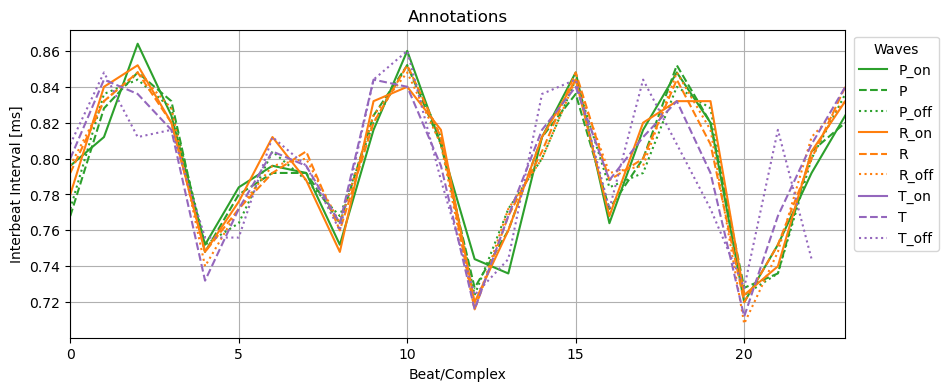

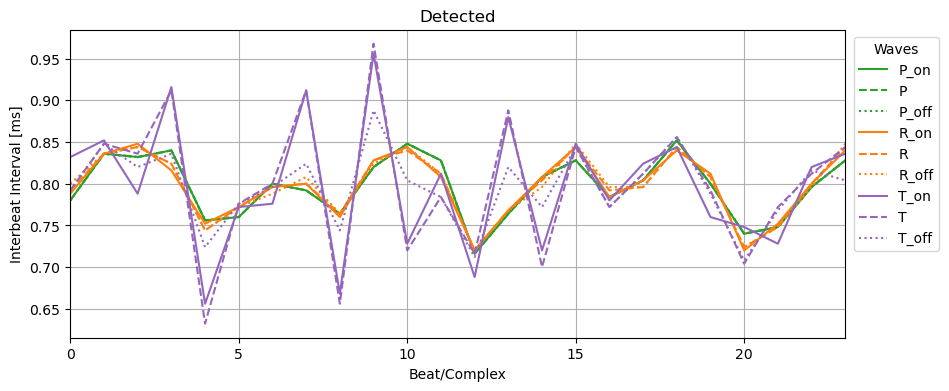

In [5]:
plot_interbeat(annotations, fs, title="Annotations")
plot_interbeat(waves, fs, title="Detected")

# filterpy


Initialize the Kalman Filter

In [68]:
from filterpy.stats import plot_covariance_ellipse
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag

R_std = .3
Q_std = .3

tracker = KalmanFilter(dim_x=4, dim_z=3)
dt = 1.0   # time step

# state transition matrix
tracker.F = np.array([[1, 0, 0, dt],
                      [0, 1, 0, dt],
                      [0, 0, 1, dt],
                      [0, 0, 0, 1]])
#tracker.F = np.eye(4)
#tracker.F[:-1, -1] = dt
# Measurement function
tracker.H = np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, 0]])


# Measurement uncertainty
tracker.R = np.array([[1, 0, 0],
                      [0, 1, 0],
                      [0, 0, 2]]) * R_std**2
# Process noise
tracker.Q = Q_discrete_white_noise(dim=tracker.dim_x, dt=dt, var=Q_std**2)
# Initial state
tracker.x = np.array([[waves["P"][0], waves["R"][0], waves["T"][0], 0]]).T
# State covariance
tracker.P = np.eye(4) * 50

Run the Kalman Filter

In [69]:
# Measurements / Detections
zs = np.array([waves["P"], waves["R"], waves["T"]]).T
# run filter
mu, cov, _, _ = tracker.batch_filter(zs)

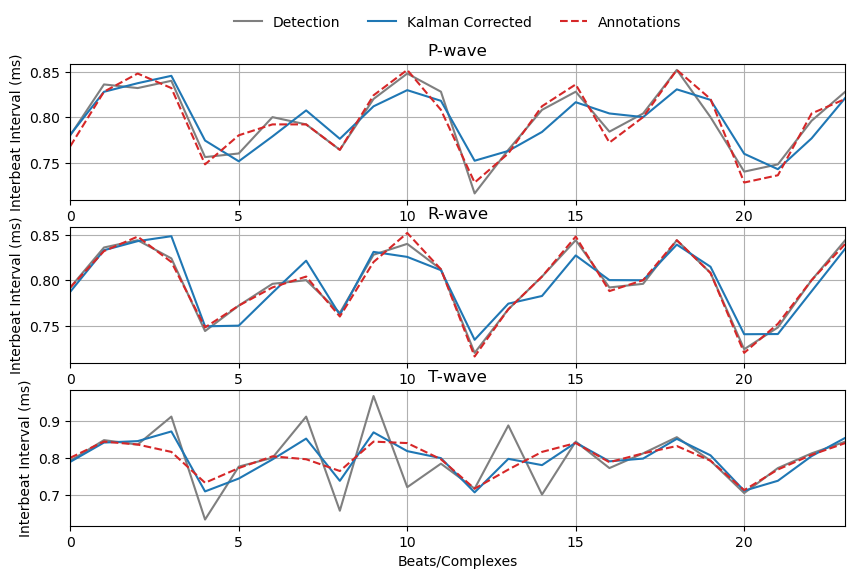

In [70]:
plot_results(zs, mu, annotations, ["P", "R", "T"], fs)       

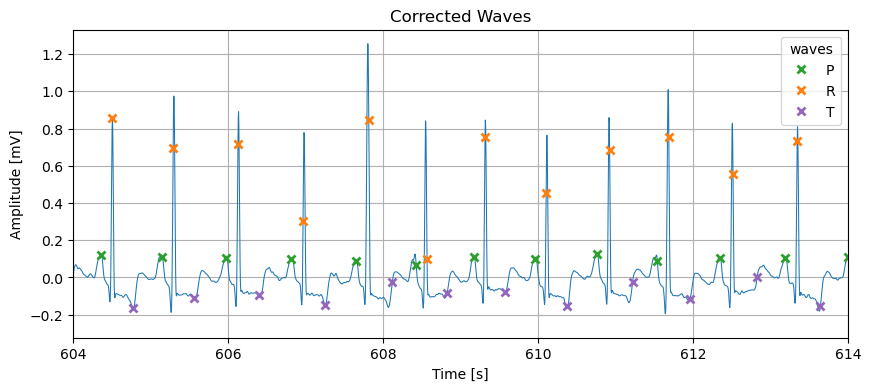

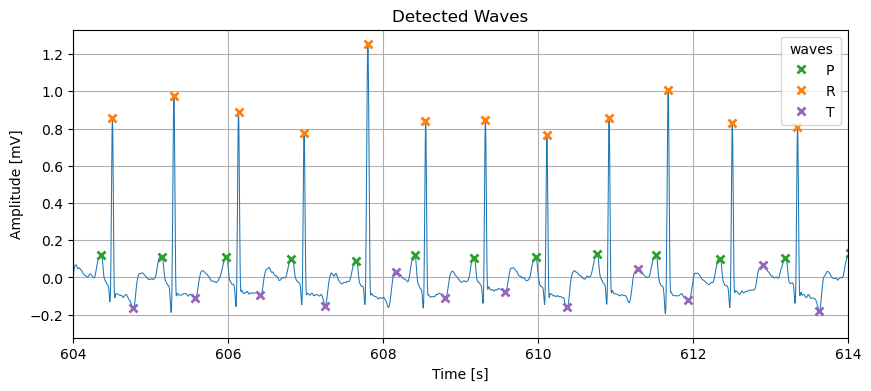

In [61]:
corrected_waves = {
    "P": mu[:, 0].astype(int),
    "R": mu[:, 1].astype(int),
    "T": mu[:, 2].astype(int)
    }
detected_waves = dict((k, waves[k]) for k in ("P", "R", "T"))

plot_waves(time, ecg, corrected_waves, title="Corrected Waves", xlim=[time[0], time[0]+10])
plot_waves(time, ecg, detected_waves, title="Detected Waves", xlim=[time[0], time[0]+10])